In [1]:
import torch
from torch import nn
import numpy as np
from mapsgan import Trajectories, TrajectoryDataset
import sys
%load_ext autoreload
%autoreload 2

In [2]:
td = Trajectories('/mnt/Clouds/MapsGAN/data/eth/test')

In [3]:
tdsg = TrajectoryDataset('/mnt/Clouds/MapsGAN/data/eth/test')

## Trajectory Toy Example

In [8]:
class ToyGenerator(nn.Module):
    
    def __init__(self, input_dim = 48, hidden_dim = 20, batch_size = 32, out_len = 12):
        super().__init__()
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.linear = nn.Sequential(nn.Linear(hidden_dim, out_len*2),
                                    nn.ReLU())
        self.out_len = out_len
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return (torch.zeros(1, self.batch_size, self.hidden_dim),
                torch.zeros(1, self.batch_size, self.hidden_dim))
        
    def forward(self, z, social_feats):
        x = torch.cat((social_feats, z), dim = 2)
        out, self.hidden = self.lstm(x, self.hidden)
        x = self.linear(self.hidden[0])
        return x.view(self.out_len, self.batch_size, 2)

In [9]:
class ToySocialEncoder(nn.Module):
    
    def __init__(self, obs_len = 8, embedding_dim=16, hidden_dim=16, batch_size = 2):
        super(ToySocialEncoder, self).__init__()

        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.obs_len = obs_len
        
        self.linear = nn.Sequential(nn.Linear(2, embedding_dim),
                                    nn.ReLU())
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return (torch.zeros(1, self.batch_size, self.hidden_dim),
                torch.zeros(1, self.batch_size, self.hidden_dim))
        
    def forward(self, input_seq):
        hidden = self.init_hidden()
        embedding = torch.zeros(self.obs_len, self.batch_size, self.embedding_dim)
        for i, seq in enumerate(input_seq):
            embedding[i] = self.linear(seq)
        out, self.hidden = self.lstm(embedding, self.hidden)
        return self.hidden[0]

In [10]:
class SEplusG(nn.Module):
    
    def __init__(self, **kwargs):
        super().__init__()
        self.se = ToySocialEncoder(**kwargs['Encoder'])
        self.g = ToyGenerator(**kwargs['Generator'])
    
    def forward(self, train, z):
        x = self.se(train)
        return self.g(z, x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=2, mlp_dim=16, hidden_dim=64, num_layers=1):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.mlp_dim = mlp_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.mlp_spatial_lstm = nn.Sequential(#nn.Linear(input_dim, mlp_dim),
                                              #nn.ReLU(),
                                              nn.LSTM(#mlp_dim,
                                                      input_dim,
                                                      hidden_dim,
                                                      num_layers))
        self.mlp_bool = nn.Sequential(nn.Linear(hidden_dim, 20),
                                      nn.Sigmoid())
        
    def forward(self, input_seq):
        _, (hidden, _) = self.mlp_spatial_lstm(input_seq)
        return self.mlp_bool(hidden.squeeze()).view(20, self.input_dim)

In [203]:
tse = ToySocialEncoder()
tse(td[0]['train']).shape

torch.Size([8, 32, 16])

In [205]:
SeG = SEplusG()
z = torch.randn(8, 32, 32)
SeG(td[0]['train'], z).shape
#torch.cat((td[0]['train'], z), dim = 2)

torch.Size([12, 32, 2])

In [206]:
TGen = ToyGenerator()
z = torch.randn(32, 32, 32)
TGen(z, social_feats).shape

torch.Size([12, 32, 2])

In [48]:
td[16]['train'][:, :2]

tensor([[[7.0500, 8.4400],
         [8.0900, 8.8400]],

        [[6.9300, 8.2600],
         [8.0900, 8.8400]],

        [[6.8700, 8.0900],
         [8.0900, 8.8400]],

        [[7.0200, 7.9100],
         [8.0900, 8.8400]],

        [[7.0700, 7.7800],
         [8.0900, 8.8400]],

        [[7.1000, 7.8200],
         [8.0900, 8.8400]],

        [[6.7700, 8.0900],
         [8.0900, 8.8400]],

        [[6.7700, 8.0900],
         [8.0700, 8.8400]]])

In [11]:
# 8 to 12, embedding, only 2 agents
kwargs = {'Encoder':dict(obs_len = 8, embedding_dim=16, hidden_dim=16, batch_size = 2),
          'Generator':dict(input_dim = 18, hidden_dim = 20, batch_size = 2, out_len = 12)}
SeG = SEplusG(**kwargs)
D = Discriminator()
ganloss_G = nn.BCELoss()
l1loss_G = nn.L1Loss()
lambda_G = 2
ganloss_D = nn.BCELoss()
optimG = torch.optim.Adam(SeG.parameters(), lr = 0.01)
optimD = torch.optim.Adam(D.parameters(), lr = 0.01)
epochs = 300
loss_G_l1_list = []
loss_G_gan_list = []
loss_D_list = []
#hidden = SeG.g.init_hidden()
for epoch in range(epochs):
    data_idx = 0#np.random.choice([0, 25, 38, 59, 42])#epoch%len(td)#np.random.randint(len(td))#np.random.choice([0, 25, 38, 59, 42])#np.random.randint(5) # len(td)) # get random sample
    labels = td[data_idx]['lossmask'][:, :2] # get lossmask (20, 32)
    train = td[data_idx]['train'][:, :2]
    prediction = td[data_idx]['groundtruth'][:, :2]
    groundtruth = torch.cat((train, prediction), dim = 0)  # groundtruth (20, 32, 2)
    z = torch.randn(8, 2, 2)
    
    '''Train generator'''
    loss_G = 0
    optimG.zero_grad()
    estimate = SeG(train, z) # prediction is of length 12
    out_D_pred = D(torch.cat((train, estimate), dim = 0))
    loss_G_l1 = l1loss_G(estimate, prediction) # l1loss
    loss_G_l1_list.append(loss_G_l1)
    loss_G_gan = ganloss_G(out_D_pred, labels) # ganloss
    loss_G_gan_list.append(loss_G_gan)
    loss_G = lambda_G*loss_G_l1 + loss_G_gan
    loss_G.backward(retain_graph = True)
    optimG.step()

    '''Train discriminator'''
    optimD.zero_grad()
    loss_D = 0
    out_D_real = D(groundtruth)
    out_D_fake = D(torch.cat((train, estimate), dim = 0))
    loss_D += ganloss_D(out_D_real, labels) # on real
    loss_D += ganloss_D(out_D_fake, ((labels-1)*(-1))) # on fake
    loss_D_list.append(loss_D)
    loss_D.backward(retain_graph = True)
    optimD.step()

    print("epoch: %d, loss_G_total: %1.3f, loss_G_l1: %1.3f, loss_G_gan: %1.3f, loss_D: %1.3f"%(epoch+1, loss_G, loss_G_l1, loss_G_gan, loss_D))  

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 2. Got 1 and 8 in dimension 0 at /opt/conda/conda-bld/pytorch-cpu_1532578932944/work/aten/src/TH/generic/THTensorMath.cpp:3616

In [68]:
prediction[:, 0], estimate[:, 0]

(tensor([[10.3100,  5.9700],
         [ 9.5700,  6.2400],
         [ 8.7300,  6.3400],
         [ 7.9400,  6.5000],
         [ 7.1700,  6.6200],
         [ 6.4700,  6.6800],
         [ 5.8600,  6.8200],
         [ 5.2400,  6.9800],
         [ 4.8700,  7.1600],
         [ 4.5100,  7.5800],
         [ 4.2000,  7.3000],
         [ 3.9500,  7.7100]]), tensor([[0.0000, 6.0941],
         [9.5477, 6.9327],
         [8.6940, 7.1441],
         [4.9717, 0.0000],
         [7.1611, 6.6788],
         [0.0000, 6.7028],
         [0.0000, 6.0941],
         [9.5478, 6.9328],
         [8.6941, 7.1441],
         [4.9718, 0.0000],
         [7.1612, 6.6789],
         [0.0000, 6.7028]], grad_fn=<SelectBackward>))

In [7]:
# 8 to 12, embedding, variable amount of agents
SeG = SEplusG()
D = Discriminator()
ganloss_G = nn.BCELoss()
l1loss_G = nn.L1Loss()
lambda_G = 1
ganloss_D = nn.BCELoss()
optimG = torch.optim.Adam(SeG.parameters(), lr = 0.01)
optimD = torch.optim.Adam(D.parameters(), lr = 0.01)
epochs = 500
loss_G_l1_list = []
loss_G_gan_list = []
loss_D_list = []
#hidden = SeG.g.init_hidden()
for epoch in range(epochs):
    data_idx = epoch%len(td)#np.random.randint(len(td))#np.random.choice([0, 25, 38, 59, 42])#np.random.randint(5) # len(td)) # get random sample
    labels = td[data_idx]['lossmask'] # get lossmask (20, 32)
    train = td[data_idx]['train']
    groundtruth = torch.cat((train, td[data_idx]['groundtruth']), dim = 0)  # groundtruth (20, 32, 2)
    z = torch.randn(8, 32, 32)
    
    '''Train generator'''
    loss_G = 0
    optimG.zero_grad()
    prediction = SeG(train, z) # prediction is of length 12
    out_D_pred = D(torch.cat((train, prediction), dim = 0))
    loss_G_l1 = l1loss_G(prediction[:,  0:td.peds_per_seq[data_idx]], groundtruth[8::,  0:td.peds_per_seq[data_idx]]) # l1loss
    loss_G_l1_list.append(loss_G_l1)
    loss_G_gan = ganloss_G(out_D_pred.squeeze()[:, 0:td.peds_per_seq[data_idx]], labels[:, 0:td.peds_per_seq[data_idx]]) # ganloss
    loss_G_gan_list.append(loss_G_gan)
    loss_G = lambda_G*loss_G_l1 + loss_G_gan
    loss_G.backward(retain_graph = True)
    optimG.step()

    '''Train discriminator'''
    optimD.zero_grad()
    loss_D = 0
    out_D_real = D(groundtruth)
    out_D_fake = D(torch.cat((train, prediction), dim = 0))
    loss_D += ganloss_D(out_D_real.squeeze()[:, 0:td.peds_per_seq[data_idx]], labels[:, 0:td.peds_per_seq[data_idx]]) # on real
    loss_D += ganloss_D(out_D_fake.squeeze()[:, 0:td.peds_per_seq[data_idx]], ((labels-1)*(-1))[:, 0:td.peds_per_seq[data_idx]]) # on fake
    loss_D_list.append(loss_D)
    loss_D.backward()
    optimD.step()

    print("epoch: %d, loss_G_total: %1.3f, loss_G_l1: %1.3f, loss_G_gan: %1.3f, loss_D: %1.3f"%(epoch+1, loss_G, loss_G_l1, loss_G_gan, loss_D))  

epoch: 1, loss_G_total: 7.813, loss_G_l1: 7.121, loss_G_gan: 0.692, loss_D: 1.385
epoch: 2, loss_G_total: 7.966, loss_G_l1: 7.273, loss_G_gan: 0.692, loss_D: 1.367
epoch: 3, loss_G_total: 8.662, loss_G_l1: 7.964, loss_G_gan: 0.698, loss_D: 1.360
epoch: 4, loss_G_total: 8.627, loss_G_l1: 7.927, loss_G_gan: 0.700, loss_D: 1.348
epoch: 5, loss_G_total: 8.606, loss_G_l1: 7.901, loss_G_gan: 0.705, loss_D: 1.336
epoch: 6, loss_G_total: 8.567, loss_G_l1: 7.855, loss_G_gan: 0.712, loss_D: 1.325
epoch: 7, loss_G_total: 8.497, loss_G_l1: 7.776, loss_G_gan: 0.721, loss_D: 1.316
epoch: 8, loss_G_total: 8.386, loss_G_l1: 7.646, loss_G_gan: 0.740, loss_D: 1.301
epoch: 9, loss_G_total: 8.284, loss_G_l1: 7.512, loss_G_gan: 0.772, loss_D: 1.279
epoch: 10, loss_G_total: 8.193, loss_G_l1: 7.356, loss_G_gan: 0.837, loss_D: 1.235
epoch: 11, loss_G_total: 8.115, loss_G_l1: 7.140, loss_G_gan: 0.974, loss_D: 1.161
epoch: 12, loss_G_total: 8.202, loss_G_l1: 6.936, loss_G_gan: 1.266, loss_D: 1.022
epoch: 13, lo

In [18]:
prediction[:, 1]

tensor([[2.7231, 7.9609],
        [3.3286, 8.0379],
        [4.0818, 7.9306],
        [2.7376, 8.0046],
        [3.3288, 8.0389],
        [4.0815, 7.9301],
        [2.7379, 8.0050],
        [3.3289, 8.0391],
        [4.0815, 7.9300],
        [2.7377, 8.0046],
        [3.3290, 8.0390],
        [4.0818, 7.9307]], grad_fn=<SelectBackward>)

In [22]:
idx = 32
SeG(td[idx]['train'], torch.randn(8, 32, 32))[:, 1], td[idx]['groundtruth'][:, 0]

(tensor([[2.7447, 8.0896],
         [3.3645, 8.1810],
         [4.1176, 8.0754],
         [2.7769, 8.1577],
         [3.3650, 8.1819],
         [4.1173, 8.0751],
         [2.7768, 8.1580],
         [3.3648, 8.1813],
         [4.1180, 8.0756],
         [2.7770, 8.1580],
         [3.3649, 8.1820],
         [4.1179, 8.0760]], grad_fn=<SelectBackward>),
 tensor([[ 1.3400,  5.3400],
         [ 2.2800,  5.2700],
         [ 3.1800,  5.2000],
         [ 4.1100,  5.1600],
         [ 5.0300,  5.0900],
         [ 6.0200,  5.0400],
         [ 7.0100,  5.0300],
         [ 8.0500,  4.9600],
         [ 8.9400,  4.8900],
         [ 9.8800,  4.8400],
         [10.7400,  4.7500],
         [11.7000,  4.6000]]))

In [108]:
np.random.choice([0, 25, 38, 59, 42])

38

In [104]:
td[42]['train']

tensor([[[12.5000,  3.8300],
         [10.7400,  7.2000],
         [-0.1700,  6.3200],
         [11.2300,  6.6500],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[12.3700,  3.7400],
         [ 9.7200,  7.1000],
         [ 0

In [6]:
# 20 seq len fixed, no embedding
TGen = ToyGenerator()
D = Discriminator()
ganloss_G = nn.BCELoss()
l1loss_G = nn.L1Loss()
lambda_G = 2
ganloss_D = nn.BCELoss()
optimG = torch.optim.Adam(TGen.parameters(), lr = 0.01)
optimD = torch.optim.Adam(D.parameters(), lr = 0.01)
epochs = 500
loss_G_l1_list = []
loss_G_gan_list = []
loss_D_list = []
for epoch in range(epochs):
    data_idx = np.random.randint(5) # len(td)) # get random sample
    labels = td[data_idx]['lossmask'] # get lossmask (20, 32)
    groundtruth = torch.cat((td[data_idx]['train'], td[data_idx]['groundtruth']), dim = 0)  # groundtruth (20, 32, 2)
    
    '''Train generator'''
    loss_G = 0
    optimG.zero_grad()
    z = torch.randn(32, 32, 32)
    prediction = TGen(z)
    out_D_pred = D(prediction)
    loss_G_l1 = l1loss_G(prediction[:,  0:td.peds_per_seq[data_idx]], groundtruth[:,  0:td.peds_per_seq[data_idx]]) # l1loss
    loss_G_l1_list.append(loss_G_l1)
    loss_G_gan = ganloss_G(out_D_pred.squeeze()[:, 0:td.peds_per_seq[data_idx]], labels[:, 0:td.peds_per_seq[data_idx]]) # ganloss
    loss_G_gan_list.append(loss_G_gan)
    loss_G = lambda_G*loss_G_l1 + loss_G_gan
    loss_G.backward(retain_graph=True)
    optimG.step()

    '''Train discriminator'''
    optimD.zero_grad()
    loss_D = 0
    out_D_real = D(groundtruth)
    out_D_fake = D(prediction)
    loss_D += ganloss_D(out_D_real.squeeze()[:, 0:td.peds_per_seq[data_idx]], labels[:, 0:td.peds_per_seq[data_idx]]) # on real
    loss_D += ganloss_D(out_D_fake.squeeze()[:, 0:td.peds_per_seq[data_idx]], ((labels-1)*(-1))[:, 0:td.peds_per_seq[data_idx]]) # on fake
    loss_D_list.append(loss_D)
    loss_D.backward(retain_graph=True)
    optimD.step()

    print("epoch: %d, loss_G_total: %1.3f, loss_G_l1: %1.3f, loss_G_gan: %1.3f, loss_D: %1.3f"%(epoch+1, loss_G, loss_G_l1, loss_G_gan, loss_D))  

epoch: 1, loss_G_total: 15.258, loss_G_l1: 7.285, loss_G_gan: 0.688, loss_D: 1.386
epoch: 2, loss_G_total: 16.645, loss_G_l1: 7.975, loss_G_gan: 0.694, loss_D: 1.370
epoch: 3, loss_G_total: 16.623, loss_G_l1: 7.960, loss_G_gan: 0.703, loss_D: 1.353
epoch: 4, loss_G_total: 16.574, loss_G_l1: 7.930, loss_G_gan: 0.715, loss_D: 1.337
epoch: 5, loss_G_total: 15.776, loss_G_l1: 7.518, loss_G_gan: 0.740, loss_D: 1.322
epoch: 6, loss_G_total: 15.204, loss_G_l1: 7.224, loss_G_gan: 0.755, loss_D: 1.314
epoch: 7, loss_G_total: 16.558, loss_G_l1: 7.902, loss_G_gan: 0.754, loss_D: 1.307
epoch: 8, loss_G_total: 15.167, loss_G_l1: 7.181, loss_G_gan: 0.806, loss_D: 1.285
epoch: 9, loss_G_total: 16.551, loss_G_l1: 7.845, loss_G_gan: 0.862, loss_D: 1.256
epoch: 10, loss_G_total: 16.577, loss_G_l1: 7.793, loss_G_gan: 0.992, loss_D: 1.129
epoch: 11, loss_G_total: 15.306, loss_G_l1: 7.016, loss_G_gan: 1.274, loss_D: 0.962
epoch: 12, loss_G_total: 16.701, loss_G_l1: 7.622, loss_G_gan: 1.456, loss_D: 0.879
e

In [7]:
z = torch.randn(32, 32, 32)
predicted = TGen(z)

In [8]:
predicted[0, 0:td.peds_per_seq[data_idx]], groundtruth[0,0:td.peds_per_seq[data_idx]]

(tensor([[7.2274, 7.6265],
         [8.3665, 8.2747]], grad_fn=<SliceBackward>),
 tensor([[10.3100,  5.9700],
         [12.4900,  6.6000]]))

In [42]:
import matplotlib.pyplot as plt

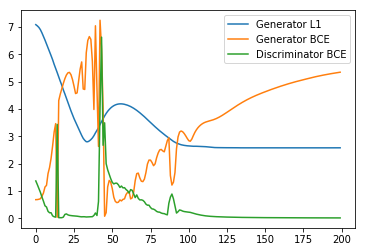

In [69]:
plt.plot(loss_G_l1_list[0:200], label = 'Generator L1')
plt.plot(loss_G_gan_list[0:200], label = 'Generator BCE')
plt.plot(loss_D_list[0:200], label = 'Discriminator BCE')
plt.legend()